In [1]:
import feather
import pandas as pd
from tqdm import tqdm

In [2]:
from outliers import remove_outliers
from feature_gen import add_trend_features, add_penultimate_week
from feature_gen import add_window_trend_features, add_last_features

from feature_gen import add_window_mean_overall_features
from feature_gen import add_window_mean_dow_features
from feature_gen import add_window_mean_weekend_features

In [3]:
df_user_view = pd.read_csv('data/user_view.txt', header=None)
df_user_view.columns = ['user_id', 'shop_id', 'ts']
df_user_view.shop_id = df_user_view.shop_id.astype('uint16')
df_user_view.user_id = df_user_view.user_id.astype('uint32')
df_user_view.ts = pd.to_datetime(df_user_view.ts)
df_user_view['day'] = df_user_view.ts.dt.floor(freq='d')

df_views = df_user_view.groupby(by=['shop_id', 'day']).user_id.count().reset_index()
df_views.rename(columns={'user_id': 'views_count'}, inplace=1)

df_views.shop_id = df_views.shop_id.astype('uint16')

In [4]:
df_pays = feather.read_dataframe('data/df_pays_na_test.feather')

In [5]:
df_views_joined = df_pays.merge(df_views, on=['shop_id', 'day'], how='left')

In [6]:
import seaborn as sns
%matplotlib inline

In [29]:
df_shop = df_views_joined[df_views_joined.shop_id == 8]

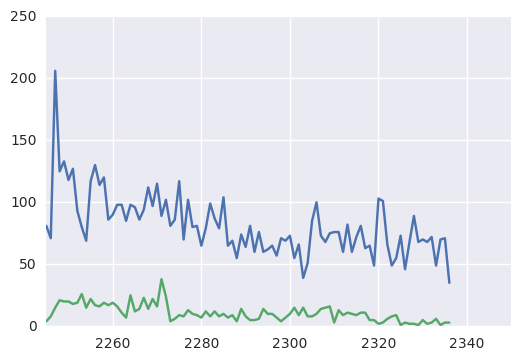

In [30]:
df_shop.pays_count.plot()
df_shop.views_count.plot()

In [6]:
original_cols = set(df_views_joined.columns)

In [7]:
def new_names(cols):
    result = []
    for c in cols:
        if c in original_cols:
            result.append(c)
        else:
            result.append('views_' + c)
    return result

In [8]:
shops = df_pays.shop_id.unique()
shops = sorted(shops)

dfs = []

for i in tqdm(shops):
    df_shop = df_views_joined[df_views_joined.shop_id == i].reset_index(drop=1)
    
    try:
        remove_outliers(df_shop, target='views_count')
    except:
        pass

    try:
        add_penultimate_week(df_shop, target='views_count')
    except:
        pass

    try:
        add_trend_features(df_shop, target='views_count')
    except:
        pass

    try:
        add_window_trend_features(df_shop, target='views_count')
    except:
        pass

    try:
        add_window_mean_overall_features(df_shop, past_biweeks_list=[1, 2, 3], target='views_count')
    except:
        pass
    try:
        add_window_mean_dow_features(df_shop, past_biweeks_list=[2, 3], target='views_count')
    except:
        pass
    
    try:
        add_window_mean_weekend_features(df_shop, past_biweeks_list=[2, 3], target='views_count')
    except:
        pass

    try:
        add_last_features(df_shop, target='views_count')
    except:
        pass

    df_shop.columns = new_names(df_shop.columns)
    dfs.append(df_shop)

100%|██████████| 2000/2000 [3:03:19<00:00,  5.04s/it]


In [9]:
truncated_dfs = []

for df in dfs:
    df = df.iloc[7 * 2 * 3:]
    truncated_dfs.append(df)

In [10]:
df_features = pd.concat(truncated_dfs).reset_index(drop=1)

In [11]:
feather.write_dataframe(df_features, 'features/view_features.feather')